# Reference level cross validation
In scenarios where you have no prior knowledge of the elevation of the density contrast of interest, we use a flat starting model with an arbitrary reference level. The reference level (`zref`) is very important to the inversion as different values can vertically shift the inverted topography. Here we present a cross-validation approach to determine the optimal value for `zref`. This follows the same approach as the past notebook (`density_cross_validation.ipynb`). To simplify, we assume we know the appropiate density constrast value to use. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle

import numpy as np
import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Create observed gravity data

### True topography

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.262348539866753 m
INFO:invert4geom:Standard deviation used for noise: [0.2]


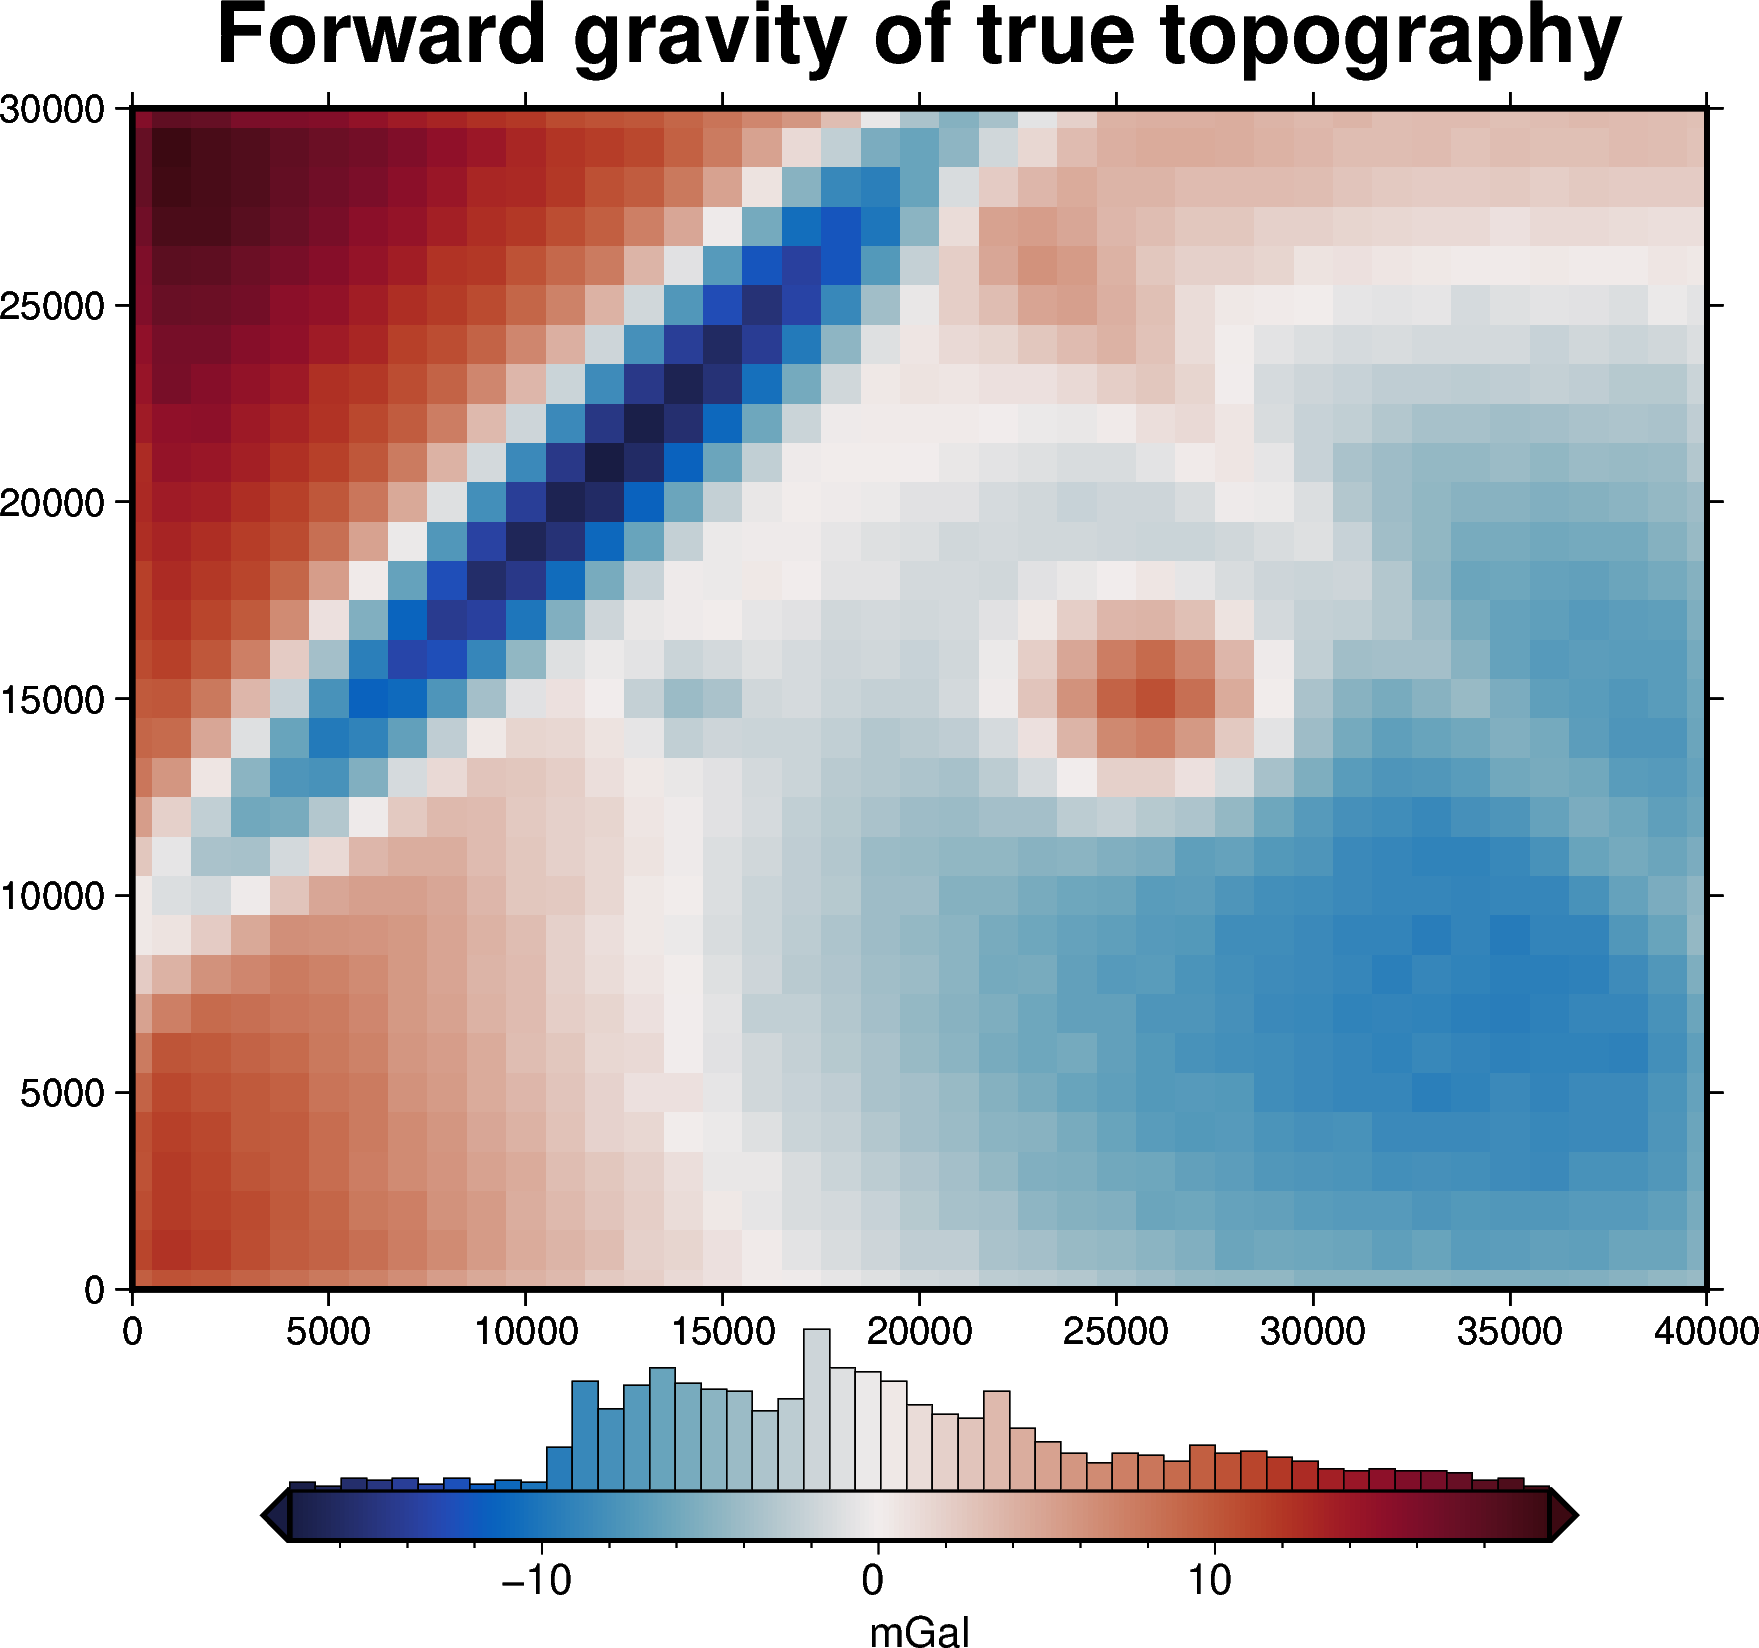

mean of true topography: 492.2704164812973 m 


In [2]:
# set grid parameters
spacing = 1000
region = (0, 40000, 0, 30000)

# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

(
    true_topography,
    _,
    constraint_points,
    grav_df,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    number_of_constraints=10,
    density_contrast=true_density_contrast,
    plot_topography_diff=False,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

For simplicity here we assume that we know the optimal density contrast value and use this when creating our starting model.

What we don't know in this scenario is what reference elevation `zref` to use. We will use a cross-validation of a range of elevations to find the one which is optimal.

Each `zref` will give a cross validation score, and the lowest score will show which `zref` is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points, same as in the past nootebook. 

## Get Cross Validation Score

First we need to use the `zref` value to create the starting model. We will then use this in an inversion to calculate a `score`.

In [3]:
# set a zref value
zref = 300  # instead of the correct value of ~490 m

# assume we know the optimal density contrast value
density_contrast = true_density_contrast

# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["gravity_anomaly"]
grav_df["reg"] = 0
grav_df["res"] = grav_df.misfit

# set kwargs to pass to the inversion
kwargs = {
    "solver_damping": 0.1,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.45,  # gravity error is .2 mGal or L2-norm of ~0.45
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score
score, _ = cross_validation.constraints_cv_score(
    grav_df=grav_df,
    constraints_df=constraint_points,
    prism_layer=starting_prisms,
    **kwargs,
)
print(f"CV score: {score}")

CV score: 193.78203973944062


## Cross Validation
Lets see if we can improve the score with other values for zref. For each zref value we need to recreate the starting prism model, forward calculate its starting gravity, and recalculate the gravity misfit, including the regional and residual components. Then we can re-run the inversion.

This is a classic optimization problem, where we vary the zref to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, `optimize_inversion_zref_density_contrast` will use a sampler to choose zref values between the provided `zref_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test zref values at a constant interval, you can set `grid_search` to True, and this will test all zref values as defined by:

```python
np.linspace(<<lower zref limit>>, <<upper zref limit>>, n_trials)
```

In [4]:
grav_df.describe()

,northing,easting,upward,gravity_anomaly,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.129304,-0.129304,0.0,-0.129304
std,8947.792584,11836.81698,0.0,7.148580,7.148580,0.0,7.148580
min,0.000000,0.00000,1000.0,-17.498175,-17.498175,0.0,-17.498175
25%,7000.000000,10000.00000,1000.0,-5.603815,-5.603815,0.0,-5.603815
50%,15000.000000,20000.00000,1000.0,-1.150991,-1.150991,0.0,-1.150991
75%,23000.000000,30000.00000,1000.0,3.750980,3.750980,0.0,3.750980
max,30000.000000,40000.00000,1000.0,19.930660,19.930660,0.0,19.930660


In [5]:
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    zref_limits=[400, 600],
    density_contrast=true_density_contrast,
    n_trials=6,
    starting_topography_kwargs={
        "method": "flat",
        "region": region,
        "spacing": spacing,
    },
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    # grid_search=True,
    plot_cv=False,
    fname="../tmp/zref_CV",
    **kwargs,
)

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:starting_topography not provided, creating a starting topography model with the supplied starting_topography_kwargs
INFO:invert4geom:using zref to create a flat starting topography model


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:invert4geom:starting_topography not provided, creating a starting topography model with the supplied starting_topography_kwargs
INFO:invert4geom:using zref to create a flat starting topography model
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'zref': 492.5210924794312}
INFO:invert4geom:	scores: [2.370077893644822]


In [6]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/zref_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/zref_CV_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

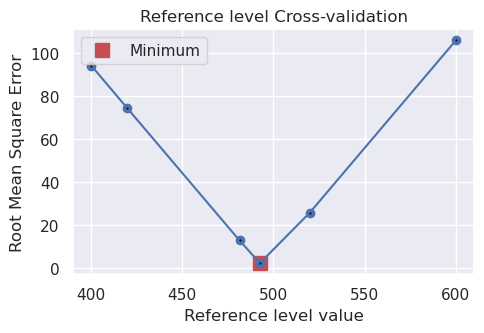

In [7]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_zref.values,
    param_name="Reference level",
    logx=False,
    logy=False,
)

Lets see how the cross-validation perform by comparing the estimated `best` reference level value to the true value used to create the observed gravity.

In [ ]:
print(
    f"True zref value: {true_zref}, best zref from CV: {study.best_params.get('zref')}"
)

In [ ]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results


plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.15c",
)

## Run inversion with poor choice of reference level

In [ ]:
# set Python's logging level
logging.getLogger().setLevel(logging.WARNING)

# set a bad reference level
bad_zref = 300

results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    starting_topography_kwargs={
        "method": "flat",
        "upwards": bad_zref,
        "region": region,
        "spacing": spacing,
        "dampings": np.logspace(-20, 0, 50),
    },
    density_contrast=true_density_contrast,
    zref=bad_zref,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    fname="../tmp/bad_zref_CV",
    **kwargs,
)
# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [ ]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

This inversion with a zref of 300m  instead of the optimal zref of ~490m, shows that an incorrect zref will result in an inverted topography which vertically offset from the true topography. Estimating and removing a regional component of the gravity misfit may help this, but the zref cross validation is an effect tool to reduce these errors.